## Identifiación de Outliers mediante HBOS tomando como base la diferencia entre los puntos contiguos como criterio

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.metrics import *

from funciones_OD import *

ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
sensor = "pm25"
redondeo = 4
variables = ['pm25']#,'humedad_relativa', 'temperatura'
for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

Nodo: 50 Faltan: 3
Nodo: 134 Faltan: 2
Nodo: 187 Faltan: 1
Nodo: 266 Faltan: 0

Ponderaciones: {2.3522: [138509, 41318.8354, 1.0, 1.0], 4.7044: [4993, 1489.4696, 0.036, 0.036], 7.0566: [587, 175.1089, 0.0042, 0.0042], 9.4088: [180, 53.6961, 0.0013, 0.0013], 11.761: [56, 16.7054, 0.0004, 0.0004], 14.1132: [17, 5.0713, 0.0001, 0.0001], 16.4654: [12, 3.5797, 0.0001, 0.0001], 18.8176: [8, 2.3865, 0.0001, 0.0001], 21.1698: [2, 0.5966, 0.0, 0.0], 23.5219: [0, 0.0, 0.0, 0.0], 25.8741: [1, 0.2983, 0.0, 0.0], 28.2263: [0, 0.0, 0.0, 0.0], 30.5785: [1, 0.2983, 0.0, 0.0], 32.9307: [1, 0.2983, 0.0, 0.0], 35.2829: [1, 0.2983, 0.0, 0.0], 37.6351: [0, 0.0, 0.0, 0.0], 39.9873: [0, 0.0, 0.0, 0.0], 42.3395: [1, 0.2983, 0.0, 0.0]}

HBOS {0: 0.0, 1: 1.4436974992327127, 2: 2.3767507096020997, 3: 2.886056647693163, 4: 3.3979400086720375, 5: 4.0, 6: 4.0, 7: 4.0, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10}


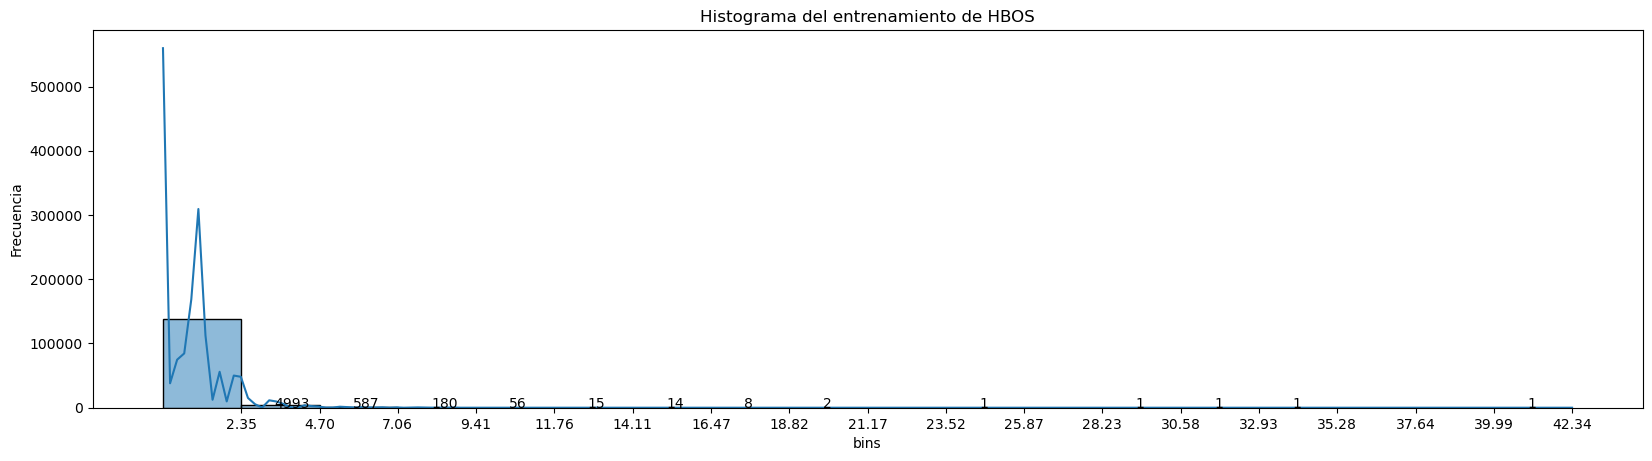

In [3]:
# ENTRENAMIENTO DE HBOS
pd.options.mode.chained_assignment = None  # default='warn'

#************** PARA DATAFRAME MEZCLADO **********************
# Solo descomentar las dos siguientes líneas
#porcentaje = 0.7
#entreno, test = df_mix (entreno,porcentaje)
#*************************************************************

#nodos_entreno = [50, 134, 187, 266]
nodos_entreno = entreno.codigoSerial.unique().tolist()
entrenamiento = pd.DataFrame()

now = datetime.now()
time_hbos = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

for i in nodos_entreno:
    inicio = datetime.now()
    print("Nodo:",i, "Faltan:", len(nodos_entreno)-(nodos_entreno.index(i)+1))
    fild = entreno.loc[entreno.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)
        
    if (len(fild)<=0):
        print("No hay datos del nodo", i)
        continue
        
    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

    entrenamiento = pd.concat([entrenamiento,fild],ignore_index=True)

HBOS = {}
hbos_inicio = datetime.now()
    
ks,kd,n,tam_bin,bins = calcula_k(entrenamiento,variables,redondeo) # Calcula los intervalos de forma dinámica y estática y el tamaño del bin para cada uno

for sensor in variables:
    
    # Asigna los valores a cada intervalo
    intervalos = asigna_ks(entrenamiento[sensor+'_dif'],bins) # Asignación de valores en intervalos de forma estática
    #intervalos = asigna_kd(n,entrenamiento[sensor],kd) # Asignación de valores en intervalos de forma dinpamica
            
    # Cálculo de ponderaciones de acuerdo con la frecuencia de cada intervalo (densidad de cada intervalo)
    ponderaciones = calcula_ponderaciones(intervalos,redondeo)
    print("\nPonderaciones:",ponderaciones)
            
    # Cálculo del scor HBOS para cada valor único.
    HBOS = calcula_HBOS(ponderaciones,HBOS)
    print("\nHBOS",HBOS)
    
hbos_fin = datetime.now()
time_hbos = time_hbos +(hbos_fin-hbos_inicio)


# GRAFICA DEL HISTOGRAMA
        
plt.figure(figsize=(20, 5), dpi=100)
sns.histplot(entrenamiento[sensor+'_dif'], bins=ks, kde=True, stat='count');
    
density, rangos, _= plt.hist(entrenamiento[sensor+'_dif'],density=True, bins=ks)
count, _= np.histogram(entrenamiento[sensor+'_dif'],bins)
for x,y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+1, y, num, fontsize=10)
                
plt.title('Histograma del entrenamiento de HBOS')
plt.xlabel('bins')
plt.ylabel('Frecuencia')
plt.xticks(bins)
    
plt.show() #dibujamos el histograma

In [4]:
# IDENTIFICACIÓN DE OUTLIERS POR HBOS  *****************************

#************** PARA DATAFRAME MEZCLADO **********************
# Solo descomentar las siguiente línea y comentar la linea "datos2 = datos.copy()"
#datos_ori, datos2, outliers = synthetic_data(test,0.1,100)
#*************************************************************


datos2 = datos.copy()
datos2=datos2.assign(HBOS="N")
ident_outliers = pd.DataFrame()
nodos = datos2.codigoSerial.unique().tolist()

margen_HBOS = 4.5

cont = 0
for i in nodos:
    fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)

    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos
    

    for k in range(1,len(fild)):
        cont += 1
    
        # Validación de cada valor contra su respectivo score HBOS
        hbos_inicio = datetime.now()
        ponde = verifica_HBOS(HBOS,fild[variables[0]+'_dif'][k-1],bins)
        #print('posicion:',k,'valor:',fild[variables[0]+'_dif'][k-1],'ponde 1:',ponde)

        if  ponde > margen_HBOS:
            ponde = verifica_HBOS(HBOS,fild[variables[0]+'_dif'][k],bins)
            #print('posicion:',k,'valor:',fild[variables[0]+'_dif'][k],'ponde 2:',ponde)
            if  ponde > margen_HBOS: 
                fild.loc[k-1,"HBOS"]= "S"         
                            
        hbos_fin = datetime.now()
        time_hbos = time_hbos +(hbos_fin-hbos_inicio)
        
    fin = datetime.now()
    
    ident_outliers = pd.concat([ident_outliers,fild],ignore_index=True)
    
print("Tiempo HBOS:", time_hbos.time())
print("Tiempo total:", fin-inicio)
print("Cantidad de valores:",len(fild))    
        
########################################################################

Tiempo HBOS: 00:00:07.798870
Tiempo total: 0:01:04.322792
Cantidad de valores: 38537


<ipython-input-5-d040be787f65>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = ident_outliers[0:30][ident_outliers['HBOS'] == 'S']


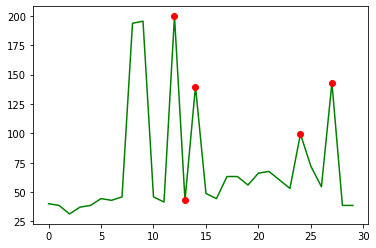

In [5]:
outliers = ident_outliers[0:30][ident_outliers['HBOS'] == 'S']
plt.plot(ident_outliers[0:30].index, ident_outliers[0:30].pm25, color="green",label="pm25")
plt.plot(outliers.index, outliers.pm25, 'o', color="red",label="Outliers")

plt.show()

In [6]:
ident_outliers[ident_outliers['HBOS'] == 'S']
#ident_outliers[0:30]

,codigoSerial,fecha,hora,temperatura,humedad_relativa,pm25,pm25_dif,pm25_outlier,HBOS
12,2,2020-02-01,00:12:00,22.43,73.94,199.6127,158.0576,40.1096,S
13,2,2020-02-01,00:13:00,22.41,74.20,43.0006,156.6121,N,S
14,2,2020-02-01,00:14:00,22.38,74.38,139.8281,96.8275,47.337,S
24,2,2020-02-01,00:28:00,22.23,76.92,99.3747,46.2557,N,S
27,2,2020-02-01,00:31:00,22.23,75.26,142.9256,88.3611,44.4461,S
...,...,...,...,...,...,...,...,...,...
38493,2,2020-02-29,18:17:00,25.89,61.30,78.0878,40.8692,31.4367,S
38504,2,2020-02-29,18:28:00,25.69,62.25,177.0897,135.5346,37.2186,S
38505,2,2020-02-29,18:29:00,25.67,62.40,80.9899,96.0998,37.2186,S
38509,2,2020-02-29,18:33:00,25.58,62.66,89.4108,47.8557,41.5551,S


In [7]:
matrix_conf (ident_outliers,'HBOS')

TP: 3613 TN: 34250 FP: 433 FN: 241
Datos totales: 38537
*************************************
Precisión: 0.8929807217004448
Exhaustividad: 0.9374675661650234
F1: 0.9146835443037975
F1: 0.9146835443037975
Exactitud: 0.9825103147624361



(34250, 241, 433, 3613)

Precisión: [0.99301267 0.89298072]
Exhaustividad: [0.9875155  0.93746757]
F1: [0.99025645 0.91468354]
Exactitud: 0.9825103147624361



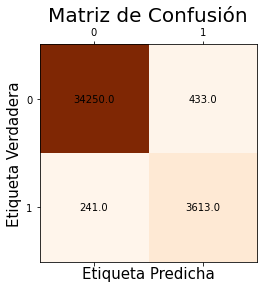

In [10]:
real = ident_outliers.pm25_outlier.tolist()
real = ['S' if value!='N' else value for value in real]
predicho = ident_outliers.HBOS.tolist()
confu_matrix (real,predicho)

